In [2]:
setwd("~/Documents/MresProject/code")

In [3]:
library(dplyr)
library(purrr)
library(ggplot2)

In [4]:
# Define the list of files, labels, and one-sided comparison methods (left/right side threshold)
file_methods <- list(
  list(file = "Density_of_segregating_sites.csv", label = "Segregating Sites", method = "below"),
  list(file = "Nucleotide_diversity_pi.csv", label = "pi", method = "below"),
  list(file = "Number_of_mutations.csv", label = "Mutation Count", method = "below"),
  list(file = "Number_of_trees.csv", label = "Tree Count", method = "below"),
  list(file = "Tajimas_D.csv", label = "Tajima's D", method = "above")
)

# Constant population

In [ ]:
##### Power Calculation Function #####
process_file <- function(file_info, folder_path) {
  file_path <- file.path(folder_path, file_info$file)
  df <- read.csv(file_path, check.names = FALSE)
  
  time_points <- sort(as.numeric(setdiff(names(df)[3:ncol(df)], "39")), decreasing = TRUE)
  
  diff_data <- do.call(rbind, lapply(time_points, function(t) {
    data.frame(
      Seed = df$Seed,
      Model = df$Model,
      timepoint = t,
      difference = df[[as.character(t)]] - df[["39"]],
      variable = file_info$label,
      stringsAsFactors = FALSE
    )
  }))
  
  # Calculate power based on one-sided method settings
  if (file_info$method == "below") {
    power_result <- diff_data %>%
      group_by(timepoint) %>%
      summarise(
        threshold = quantile(difference[Model == "constant"], probs = 0.05),
        power = mean(difference[Model == "decline"] < threshold),
        n_decline = sum(Model == "decline"),
        n_seasonal = sum(Model == "constant"),
        .groups = 'drop'
      )
  } else {
    power_result <- diff_data %>%
      group_by(timepoint) %>%
      summarise(
        threshold = quantile(difference[Model == "constant"], probs = 0.95),
        power = mean(difference[Model == "decline"] > threshold),
        n_decline = sum(Model == "decline"),
        n_seasonal = sum(Model == "constant"),
        .groups = 'drop'
      )
  }
  
  power_result$variable <- file_info$label
  power_result$method <- file_info$method
  
  return(power_result)
}

In [ ]:
datasets <- c("Constant300", "Constant3000")

# Process all datasets and combine results
all_power_results <- map_dfr(
  datasets,
  ~ map_dfr(file_methods, process_file, folder_path = file.path("../data/SingleSite", .x)) %>%
    mutate(dataset = .x)
) %>%
  mutate(
    variable = factor(variable, 
                     levels = c("Segregating Sites", "pi", 
                                "Mutation Count", "Tree Count", "Tajima's D")),
    dataset = factor(dataset, levels = datasets),
    linetype = ifelse(dataset == "Constant300", "solid", "dashed"),
    shape = ifelse(dataset == "Constant300", 16, 17)
  )

In [ ]:
variable_colors <- c(
  "Segregating Sites" = "#8e0fae",
  "pi" = "#2b55c1", 
  "Mutation Count" = "#ad5636",
  "Tree Count" = "#3b9391",
  "Tajima's D" = "#FDE725"
)

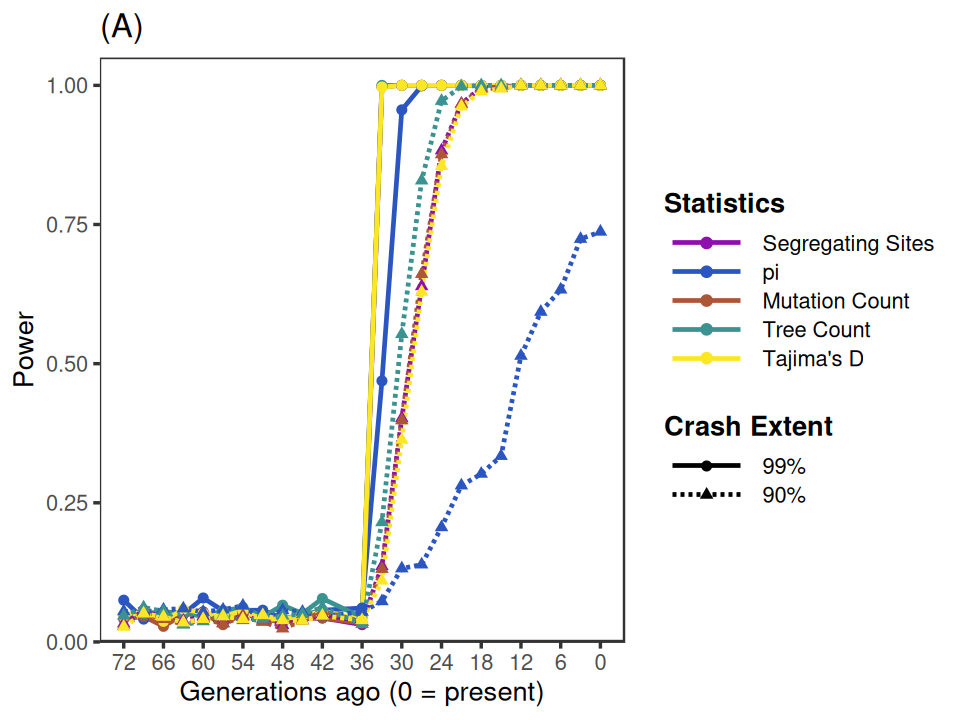

In [17]:
p3 <- ggplot(all_power_results, aes(x = timepoint, y = power)) +
  geom_line(aes(color = variable, linetype = dataset, group = interaction(variable, dataset)),
            size = 1) +
  geom_point(aes(color = variable, shape = dataset, group = interaction(variable, dataset)),
             size = 2.5) + 
  scale_x_reverse(breaks = seq(72, 0, by = -6)) +
  scale_y_continuous(limits = c(0, 1.05), expand = c(0, 0)) +
  scale_color_manual(values = variable_colors, name = "Statistics", guide = guide_legend(order = 1)) +
  scale_linetype_manual(
    name = "Crash Extent",
    values = c("Constant300" = "solid", "Constant3000" = "dashed"),
    labels = c("99%", "90%")
  ) +
  scale_shape_manual(
    name = "Crash Extent",
    values = c("Constant300" = 16, "Constant3000" = 17),
    labels = c("99%", "90%")
  ) +
  labs(title = "(A)",
       x = "Generations ago (0 = present)",
       y = "Power") +
  theme_bw(base_size = 16) +
  theme(
    legend.position = "right",
    legend.box = "vertical",
    legend.spacing.y = unit(0.3, "cm"),
    legend.title = element_text(face = "bold"),
    legend.key.width = unit(1.8, "cm"),
    panel.grid.minor = element_blank(),
    panel.grid.major = element_blank()
  )

print(p3)

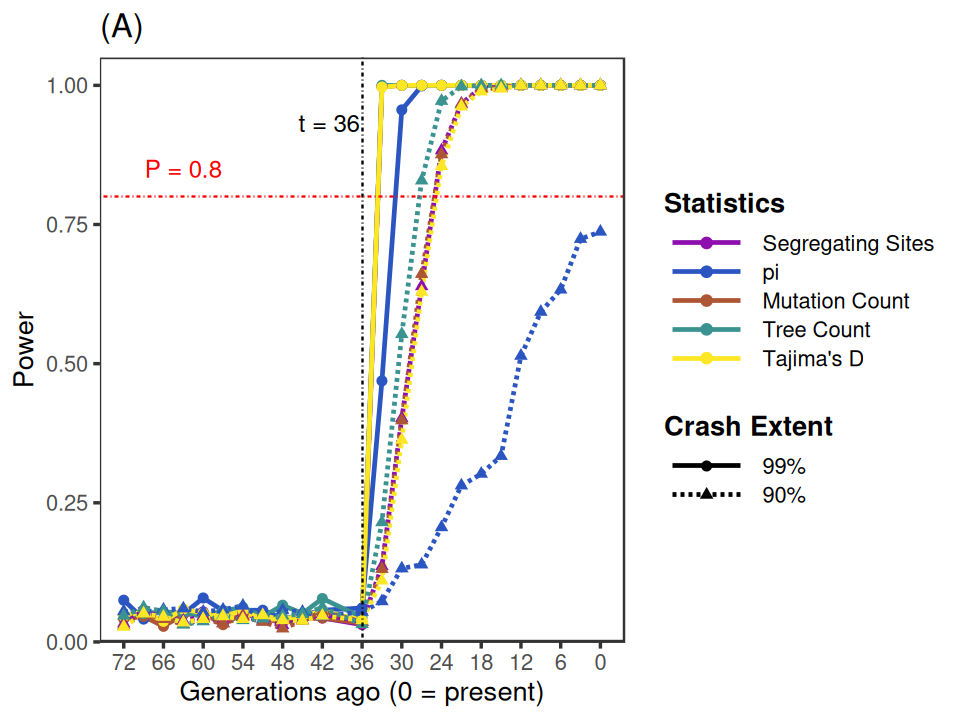

In [ ]:
p3 <- p3 + 
	geom_vline(xintercept = 36, linetype = "dotdash", color = "black") +
	geom_hline(yintercept = 0.8, linetype = "dotdash", color = "red") +
	annotate("text", x = 41, y = 0.9, label = "t = 36", color = "black", vjust = -0.5, size=5) +
	annotate("text", x = 70, y = 0.85, label = "P = 0.8", color = "red", hjust = -0.1, size=5)

p3

In [ ]:
ggsave(p3, filename = "../outputs/combined_plots/oneway_constant.pdf", width = 10, height = 6)

Proceed to the following step after you already plotted and saved "muli_constant.pdf" in `Power_multiway.ipynb`.

In [ ]:
# Combine two plots into one PDF
library(magick)

pdf1 <- image_read_pdf("../outputs/combined_plots/one_constant.pdf")
pdf2 <- image_read_pdf("../outputs/combined_plots/multi_constant.pdf")

combined <- image_append(c(pdf1, pdf2), stack = TRUE)

image_write(combined, path = "../outputs/combined_plots/constant.pdf")

# Seasonal population

In [19]:
##### Power Calculation Function #####
process_file <- function(file_info, folder_path) {
  file_path <- file.path(folder_path, file_info$file)
  df <- read.csv(file_path, check.names = FALSE)
  
  time_points <- sort(as.numeric(setdiff(names(df)[3:ncol(df)], "39")), decreasing = TRUE)
  
  diff_data <- do.call(rbind, lapply(time_points, function(t) {
    data.frame(
      Seed = df$Seed,
      Model = df$Model,
      timepoint = t,
      difference = df[[as.character(t)]] - df[["39"]],
      variable = file_info$label,
      stringsAsFactors = FALSE
    )
  }))
  
  # Calculate power based on one-sided method settings
  if (file_info$method == "below") {
    power_result <- diff_data %>%
      group_by(timepoint) %>%
      summarise(
        threshold = quantile(difference[Model == "seasonal"], probs = 0.05),
        power = mean(difference[Model == "decline"] < threshold),
        n_decline = sum(Model == "decline"),
        n_seasonal = sum(Model == "seasonal"),
        .groups = 'drop'
      )
  } else {
    power_result <- diff_data %>%
      group_by(timepoint) %>%
      summarise(
        threshold = quantile(difference[Model == "seasonal"], probs = 0.95),
        power = mean(difference[Model == "decline"] > threshold),
        n_decline = sum(Model == "decline"),
        n_seasonal = sum(Model == "seasonal"),
        .groups = 'drop'
      )
  }
  
  power_result$variable <- file_info$label
  power_result$method <- file_info$method
  
  return(power_result)
}

In [21]:
# Function to process Seasonal datasets with different DryTime
process_seasonal_data <- function(datasets, dry_time) {
  map_dfr(
    datasets,
    ~ map_dfr(file_methods, process_file, 
              folder_path = file.path("../data/SingleSite", .x, dry_time)) %>%
      mutate(dataset = .x)
  ) %>%
  mutate(
    method_label = case_when(
      method == "below" ~ "Decline < Control 5%",
      method == "above" ~ "Decline > Control 95%"
    ),
    variable = factor(variable, levels = c("Segregating Sites", "pi", 
                                         "Mutation Count", "Tree Count", "Tajima's D")),
    dataset = factor(dataset, levels = datasets),
    linetype = ifelse(dataset == "Seasonal300", "solid", "dashed"),
    shape = ifelse(dataset == "Seasonal300", 16, 17)
  )
}


datasets <- c("Seasonal300", "Seasonal3000")

dry_time_6_results <- process_seasonal_data(datasets, "DryTime_6")
dry_time_3_results <- process_seasonal_data(datasets, "DryTime_3")

In [23]:
# Define background zones for wet/dry season colors
background_zones <- data.frame(
  xstart = seq(0, 66, by = 6),
  xend = seq(6, 72, by = 6),
  fill_col = rep(c("#9bc3ec", "#ec9595"), length.out = 12)
)

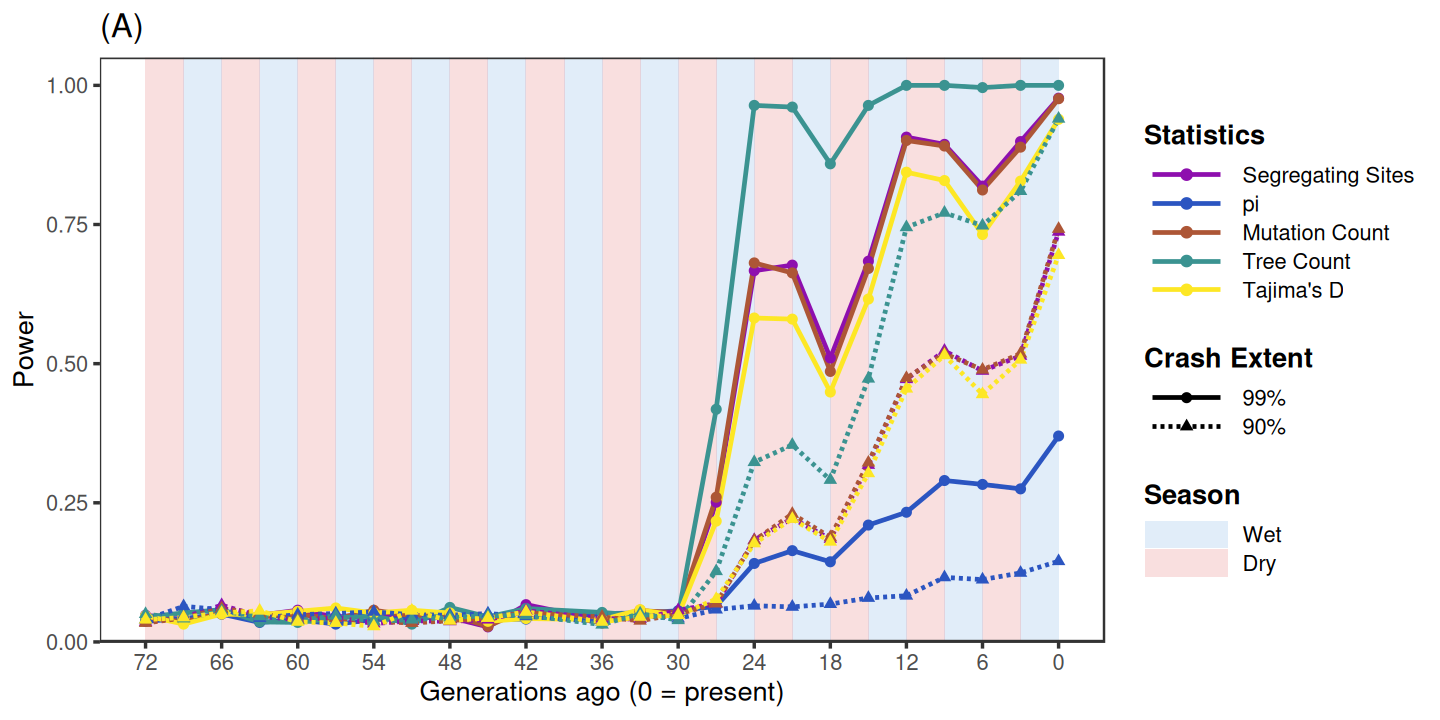

In [49]:
p1 <- ggplot(dry_time_6_results, aes(x = timepoint, y = power)) +

  geom_rect(
    data = background_zones,
    aes(xmin = xstart, xmax = xend, ymin = 0, ymax = 1.05, fill = fill_col),
    alpha = 0.3,
    inherit.aes = FALSE
  ) +
  
  geom_line(
    aes(
      color = variable,
      linetype = factor(shape),
      group = interaction(variable, shape)
    ),
    linewidth = 1
  ) +
  
  geom_point(
    aes(
      color = variable,
      shape = factor(shape),
      group = interaction(variable, shape)
    ),
    size = 2.5
  ) +
  
  scale_x_reverse(
    name = "Generations ago (0 = present)",
    breaks = seq(72, 0, by = -6)
  ) +
  scale_y_continuous(
    name = "Power",
    limits = c(0, 1.05),
    expand = c(0, 0)
  ) +
  
  scale_fill_identity(
    name = "Season",
    breaks = c("#9bc3ec", "#ec9595"),
    labels = c("Wet", "Dry"),
    guide = guide_legend(order = 3)
  ) +
  scale_color_manual(
    name = "Statistics",
    values = variable_colors,
    guide = guide_legend(order = 1)
  ) +
  scale_linetype_manual(
    name = "Crash Extent",
    values = c("16" = "solid", "17" = "dashed"),
    labels = c("99%", "90%"),
    guide = guide_legend(
      order = 2,
      override.aes = list(
        color = "black",
        shape = c(16, 17)
      ))
  ) +
  scale_shape_manual(
    name = "Crash Extent",
    values = c("16" = 16, "17" = 17),
    labels = c("99%", "90%"),
    guide = guide_legend(
      order = 2)
  ) +
  
  labs(title = "(A)") +
  
  theme_bw(base_size = 16) +
  theme(
    legend.position = "right",
    legend.box = "vertical",
    legend.spacing.y = unit(0.3, "cm"),
    legend.title = element_text(face = "bold"),
    legend.key.width = unit(1.8, "cm"),
    panel.grid.minor = element_blank(),
    panel.grid.major = element_blank()
  )

print(p1)

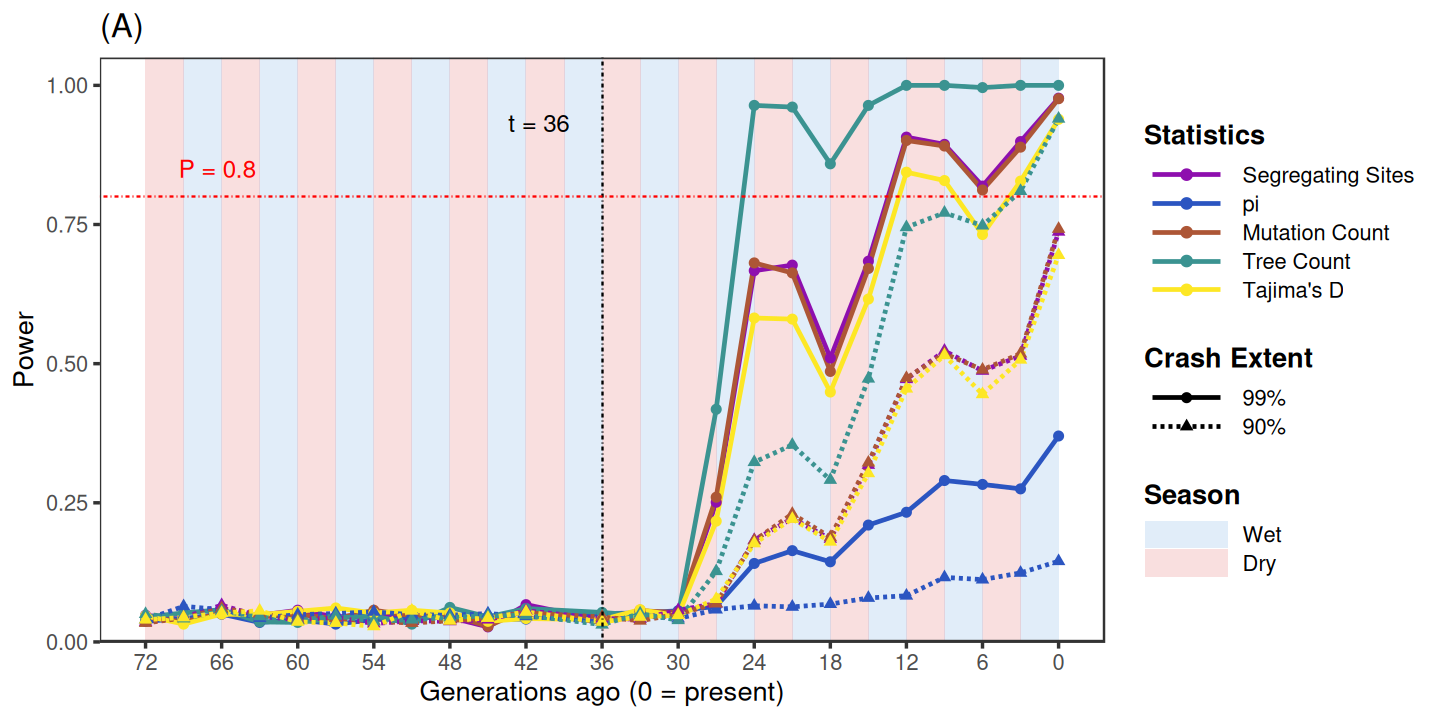

In [50]:
p1 <- p1 + 
	geom_vline(xintercept = 36, linetype = "dotdash", color = "black") +
	geom_hline(yintercept = 0.8, linetype = "dotdash", color = "red") +
	annotate("text", x = 41, y = 0.9, label = "t = 36", color = "black", vjust = -0.5, size=5) +
	annotate("text", x = 70, y = 0.85, label = "P = 0.8", color = "red", hjust = -0.1, size=5)

p1

In [26]:
background_zones <- data.frame(
  xstart = seq(0, 69, by = 3),
  xend = seq(3, 72, by = 3), 
  fill_col = rep(c("#9bc3ec", "#ec9595"), length.out = 12)
)

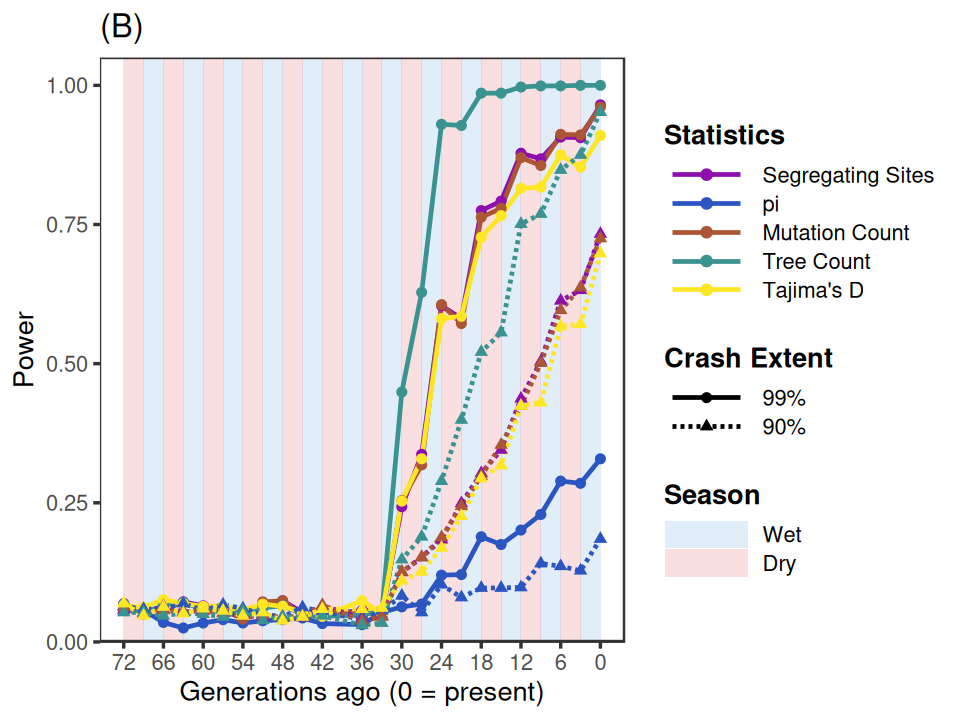

In [42]:
p2 <- ggplot(dry_time_3_results, aes(x = timepoint, y = power)) +
  
  geom_rect(
    data = background_zones,
    aes(xmin = xstart, xmax = xend, ymin = 0, ymax = 1.05, fill = fill_col),
    alpha = 0.3,
    inherit.aes = FALSE
  ) +
  
  geom_line(
    aes(
      color = variable,
      linetype = factor(shape),
      group = interaction(variable, shape)
    ),
    linewidth = 1
  ) +
  
  geom_point(
    aes(
      color = variable,
      shape = factor(shape),
      group = interaction(variable, shape)
    ),
    size = 2.5
  ) +
  
  scale_x_reverse(
    name = "Generations ago (0 = present)",
    breaks = seq(72, 0, by = -6)
  ) +
  scale_y_continuous(
    name = "Power",
    limits = c(0, 1.05),
    expand = c(0, 0)
  ) +
  
  scale_fill_identity(
    name = "Season",
    breaks = c("#9bc3ec", "#ec9595"),
    labels = c("Wet", "Dry"),
    guide = guide_legend(order = 3)
  ) +
  scale_color_manual(
    name = "Statistics",
    values = variable_colors,
    guide = guide_legend(order = 1)
  ) +
  scale_linetype_manual(
    name = "Crash Extent",
    values = c("16" = "solid", "17" = "dashed"),
    labels = c("99%", "90%"),
    guide = guide_legend(
      order = 2,
      override.aes = list(
        color = "black",
        shape = c(16, 17)
      ))
  ) +
  scale_shape_manual(
    name = "Crash Extent",
    values = c("16" = 16, "17" = 17),
    labels = c("99%", "90%"),
    guide = guide_legend(
      order = 2)
  ) +
  
  labs(title = "(B)") +
  theme_bw(base_size = 16) +
  theme(
    legend.position = "right",
    legend.box = "vertical",
    legend.spacing.y = unit(0.3, "cm"),
    legend.title = element_text(face = "bold"),
    legend.key.width = unit(1.8, "cm"),
    panel.grid.minor = element_blank(),
    panel.grid.major = element_blank()
  )

print(p2)

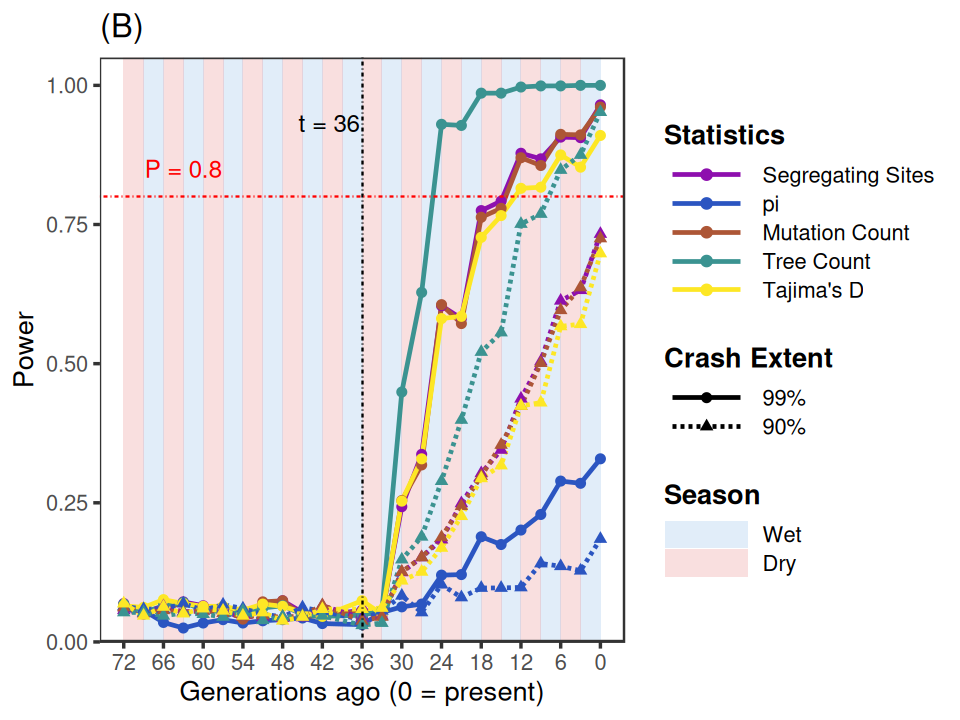

In [43]:
p2 <- p2 + 
	geom_vline(xintercept = 36, linetype = "dotdash", color = "black") +
	geom_hline(yintercept = 0.8, linetype = "dotdash", color = "red") +
	annotate("text", x = 41, y = 0.9, label = "t = 36", color = "black", vjust = -0.5, size=5) +
	annotate("text", x = 70, y = 0.85, label = "P = 0.8", color = "red", hjust = -0.1, size=5)

p2

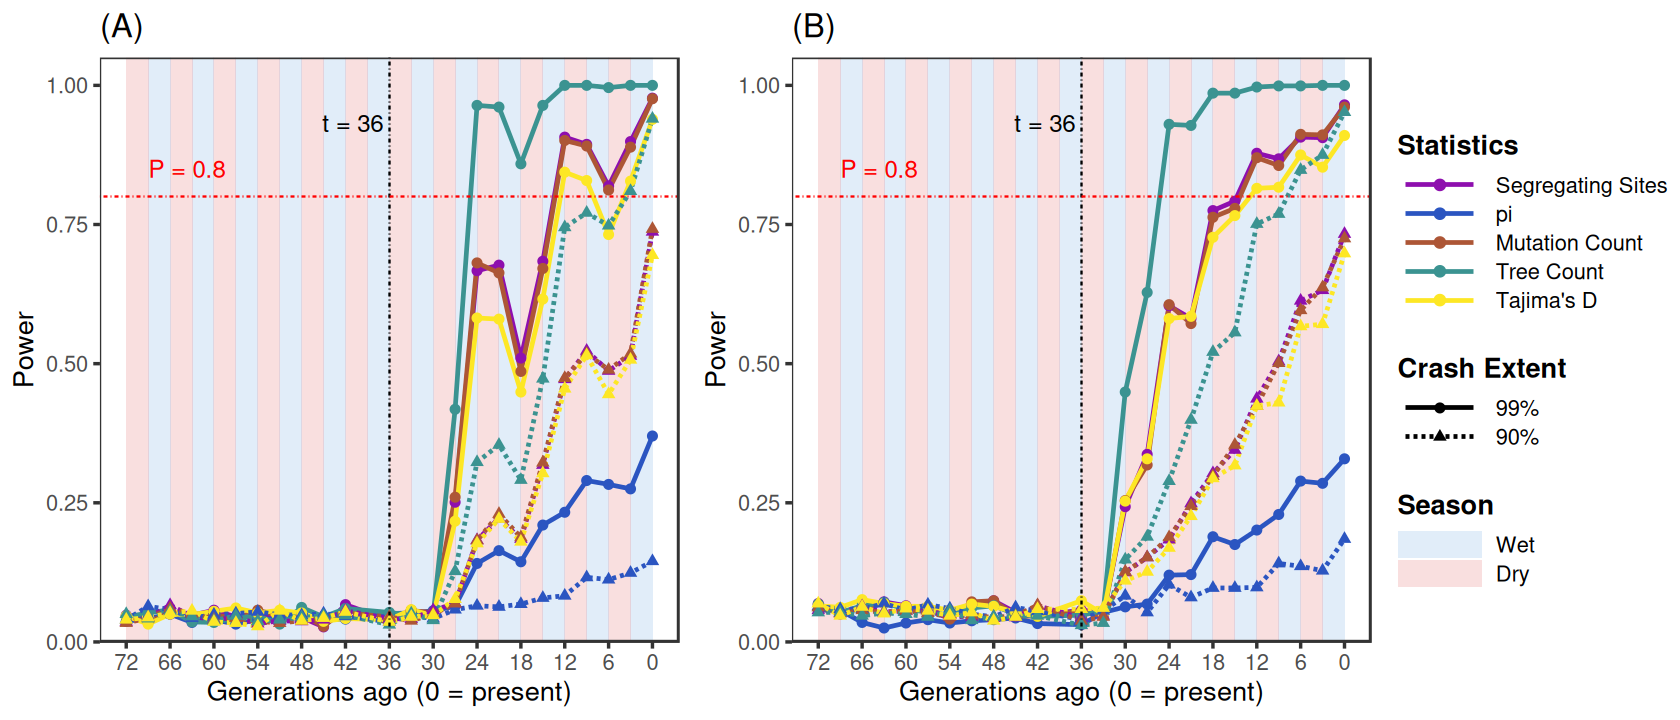

In [52]:
library(gridExtra)
library(ggpubr)

combined_plot <- ggarrange(
    p1, p2,
    ncol = 2, nrow = 1,
    widths = c(8, 8),
    heights = c(1, 1),
    common.legend = TRUE,
    legend = "right"
)
options(repr.plot.width = 14, repr.plot.height = 6)

combined_plot

In [ ]:
ggsave(combined_plot, filename = "../outputs/combined_plots/oneway_seasonal.pdf", width = 14, height = 6)

Proceed to the following step after you already plotted and saved "multi_seasonal.pdf" in `Power_multiway.ipynb`.

In [ ]:
pdf1 <- image_read_pdf("../outputs/combined_plots/oneway_seasonal.pdf")
pdf2 <- image_read_pdf("../outputs/combined_plots/multi_seasonal.pdf")

combined <- image_append(c(pdf1, pdf2), stack = TRUE)

image_write(combined, path = "../outputs/combined_plots/seasonal.pdf")
